### Proyecto: Clasificador de Objetos de Escritorio

### Entrenamiento y evaluación de un modelo CNN para reconocer objetos típicos de escritorio

Este notebook realiza el entrenamiento completo de una red neuronal convolucional (CNN) que clasifica imágenes de objetos de escritorio (monitor, teclado, ratón, taza, móvil, libro).

Además, se evalúa el modelo con métricas y visualizaciones, y se guarda el modelo entrenado.

# 1. Importar Librerías

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
import random

# 2. Realizar configuraciones

In [2]:
img_height, img_width = 150, 150  # Tamaño de las imágenes de entrada
batch_size = 32  # Tamaño de batch para entrenamiento
epochs = 50  # Número de épocas de entrenamiento

# Rutas de las carpetas
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 3. Definición de Porcentajes de División del Dataset (Train, Validation, Test)

In [3]:
# Porcentajes
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10

# 4. Verificar la estructura de las carpetas

In [4]:
assert os.path.exists(train_dir), "Falta la carpeta train/"
assert os.path.exists(val_dir), "Falta la carpeta validation/"
assert os.path.exists(test_dir), "Falta la carpeta test/"

print("Estructura de carpetas correcta.")

Estructura de carpetas correcta.


# 5. Reestructuración de imágenes

In [5]:
def balance_dataset():
    """ 
    Reestructura las carpetas para mantener la proporción 75-15-10 
    de forma balanceada para cada clase. 
    """
    classes = os.listdir(train_dir)

    for class_name in classes:
        # Obtener todas las imágenes de la clase
        class_images = []
        for folder in [train_dir, val_dir, test_dir]:
            class_folder = os.path.join(folder, class_name)
            if os.path.exists(class_folder):
                class_images.extend([os.path.join(class_folder, img) for img in os.listdir(class_folder)])

        # Asegurar que haya imágenes
        if not class_images:
            print(f"No se encontraron imágenes para la clase {class_name}.")
            continue

        random.shuffle(class_images)

        # Cálculo del reparto
        total = len(class_images)
        train_count = int(total * train_ratio)
        val_count = int(total * val_ratio)
        test_count = total - train_count - val_count

        # Verificar que se mantengan las proporciones
        print(f"Clase {class_name}: Total: {total}, Train: {train_count}, Val: {val_count}, Test: {test_count}")

        # Crear carpetas si no existen
        for folder in [train_dir, val_dir, test_dir]:
            os.makedirs(os.path.join(folder, class_name), exist_ok=True)

        # Reorganizar imágenes
        target_dirs = [
            (train_dir, train_count),
            (val_dir, val_count),
            (test_dir, test_count)
        ]

        for target_dir, count in target_dirs:
            target_class_dir = os.path.join(target_dir, class_name)

            for _ in range(count):
                if class_images:
                    img_path = class_images.pop()
                    shutil.move(img_path, os.path.join(target_class_dir, os.path.basename(img_path)))

balance_dataset()
print("Reestructuración completada.")

def mostrar_distribucion_imagenes():
    """ Muestra el número de imágenes por clase en cada carpeta. """
    print("\n--- Distribución de Imágenes ---")
    for folder in ['train', 'validation', 'test']:
        folder_path = os.path.join(base_dir, folder)
        print(f"\nCarpeta {folder.upper()}:")
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                print(f"  {class_name}: {num_images} imágenes")

mostrar_distribucion_imagenes()

Clase libro: Total: 70, Train: 52, Val: 10, Test: 8
Clase monitor: Total: 70, Train: 52, Val: 10, Test: 8
Clase móvil: Total: 70, Train: 52, Val: 10, Test: 8
Clase ratón: Total: 70, Train: 52, Val: 10, Test: 8
Clase taza: Total: 70, Train: 52, Val: 10, Test: 8
Clase teclado: Total: 70, Train: 52, Val: 10, Test: 8
Reestructuración completada.

--- Distribución de Imágenes ---

Carpeta TRAIN:
  libro: 52 imágenes
  monitor: 52 imágenes
  móvil: 52 imágenes
  ratón: 52 imágenes
  taza: 52 imágenes
  teclado: 52 imágenes

Carpeta VALIDATION:
  libro: 10 imágenes
  monitor: 10 imágenes
  móvil: 10 imágenes
  ratón: 10 imágenes
  taza: 10 imágenes
  teclado: 10 imágenes

Carpeta TEST:
  libro: 8 imágenes
  monitor: 8 imágenes
  móvil: 8 imágenes
  ratón: 8 imágenes
  taza: 8 imágenes
  teclado: 8 imágenes


# 6. Preparación de los datos

In [6]:
# Aplicamos data augmentation al conjunto de entrenamiento para mejorar la generalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 312 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 48 images belonging to 6 classes.


# 7. Modelo CNN basado en VGG16

In [7]:
# Modelo basado en VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas adicionales al modelo
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)


# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=output)

# DESCONGELAR LAS ÚLTIMAS 3 CAPAS
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Compilar el modelo
learning_rate = 0.0005  # Learning rate bajo para Transfer Learning
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
model.summary()

# Verificar número de capas entrenables
trainable_layers = sum([1 for layer in model.layers if layer.trainable])
print(f"Número de capas entrenables: {trainable_layers}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,32

 Total params: 23,761,990 (90.64 MB)

 Trainable params: 13,766,918 (52.52 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Número de capas entrenables: 11


## 7.1 Verificar generador de entrenamiento

In [8]:
for images, labels in train_generator:
    print(f"Shape de imágenes: {images.shape}")
    print(f"Shape de labels: {labels.shape}")
    break  # Salir después del primer batch

Shape de imágenes: (32, 150, 150, 3)
Shape de labels: (32, 6)


## 7.2 EarlyStopping

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## 7.3 Disminuir el learning rate si no hay mejoras

In [10]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

## 7.4 Mostrar una imagen como matriz de datos

In [11]:
# Mostrar una imagen como array de datos
ejemplo_img_path = os.path.join(train_dir, 'monitor', os.listdir(os.path.join(train_dir, 'monitor'))[0])
img = image.load_img(ejemplo_img_path, target_size=(150, 150))
img_array = image.img_to_array(img)

print("Array de la imagen:")
print(img_array)
print("\nDimensiones del array:", img_array.shape)

Array de la imagen:
[[[190. 188. 189.]
  [239. 239. 239.]
  [238. 238. 238.]
  ...
  [213. 195. 175.]
  [215. 198. 178.]
  [219. 203. 187.]]

 [[241. 241. 241.]
  [198. 198. 200.]
  [237. 237. 237.]
  ...
  [214. 197. 177.]
  [217. 200. 184.]
  [219. 202. 186.]]

 [[210. 210. 210.]
  [224. 224. 222.]
  [242. 242. 242.]
  ...
  [217. 200. 180.]
  [218. 201. 183.]
  [219. 202. 186.]]

 ...

 [[237. 221. 198.]
  [236. 218. 194.]
  [229. 211. 187.]
  ...
  [ 98.  86.  70.]
  [124. 105.  91.]
  [128. 105.  89.]]

 [[237. 219. 195.]
  [232. 214. 190.]
  [229. 211. 187.]
  ...
  [165. 138. 108.]
  [169. 142. 112.]
  [140. 120.  93.]]

 [[234. 217. 199.]
  [232. 216. 191.]
  [224. 207. 181.]
  ...
  [159. 129. 101.]
  [171. 141. 113.]
  [140. 120.  95.]]]

Dimensiones del array: (150, 150, 3)


# 8. Entrenamiento

In [12]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\Alejandra\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.2126 - loss: 2.0027 - val_accuracy: 0.2167 - val_loss: 1.6166 - learning_rate: 5.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.2459 - loss: 1.6830 - val_accuracy: 0.5667 - val_loss: 1.2923 - learning_rate: 5.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.3862 - loss: 1.5445 - val_accuracy: 0.7500 - val_loss: 1.0801 - learning_rate: 5.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.4867 - loss: 1.2982 - val_accuracy: 0.7500 - val_loss: 0.6906 - learning_rate: 5.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.5937 - loss: 1.1596 - val_accuracy: 0.7667 - val_loss: 0.6288 - learning_rate: 5.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.6671 - loss: 0.9945 - val_accuracy: 0.7333 - val_loss: 0.6576 - learning_rate: 5.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.6302 - loss:

## 8.1 Guardar el modelo entrenado

In [13]:
model.save('models/modelo_multiclase.h5')
print("Modelo guardado en 'models/modelo_multiclase.h5'")

Modelo guardado en 'models/modelo_multiclase.h5'


# 9. Visualización del entrenamiento

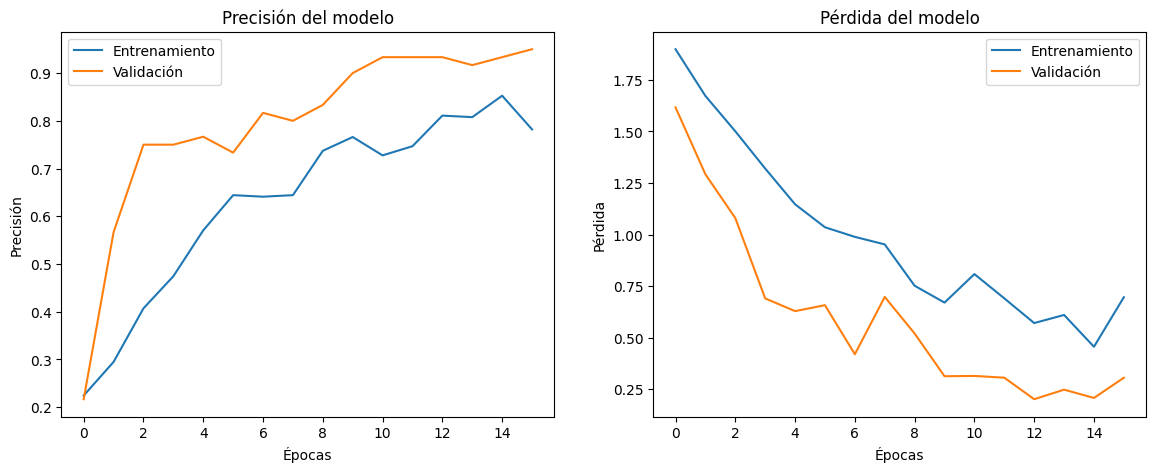

In [14]:
# Precisión
# Gráficas de Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
# Gráficas de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

### Análisis de las Gráficas de Entrenamiento

Las gráficas se ven bastante claras y muestran información importante sobre el comportamiento del modelo.

1. Gráfica de Precisión (Accuracy):
*  Curva de Entrenamiento (azul):

La precisión comienza en un nivel bajo, alrededor del 0.20 (20%), lo cual es esperado al inicio del entrenamiento.

A partir de la época 5, la curva presenta un aumento continuo, alcanzando aproximadamente 0.80 (80%) en las épocas intermedias.

En las últimas épocas, la curva sigue ascendiendo, estabilizándose en torno al 0.80, mostrando una tendencia positiva sin señales claras de saturación.


*  Curva de Validación (naranja):

La precisión de validación muestra un crecimiento rápido en las primeras épocas, alcanzando un pico alrededor de la época 6 con una precisión cercana al 80%.

Sin embargo, a diferencia de la curva de entrenamiento, la precisión de validación se mantiene más alta durante gran parte del entrenamiento, lo que puede indicar que el modelo está memorizando patrones específicos del conjunto de validación.

Al final del entrenamiento, la precisión de validación se estabiliza cerca del 0.85 - 0.90, manteniéndose superior a la curva de entrenamiento.

2. Gráfica de Pérdida (Loss):
*  Curva de Entrenamiento (azul):

La pérdida comienza alta, más de 1.75, y desciende de forma constante a partir de las primeras épocas.

En las épocas intermedias, la pérdida sigue descendiendo de manera uniforme hasta estabilizarse un poco.

En las últimas épocas, la curva muestra una ligera subida, lo que puede indicar un ligero sobreajuste al conjunto de entrenamiento.

*  Curva de Validación (naranja):

La pérdida de validación sigue una tendencia similar a la curva de entrenamiento, con una disminución rápida en las primeras épocas.

En las épocas intermedias, la pérdida de validación muestra un descenso notable, alcanzando aproximadamente 0.35 - 0.40.

En las últimas épocas, la curva muestra un aumento leve, lo que refuerza la idea de sobreajuste leve.

3. Conclusión del entrenamiento:
*  El modelo ha logrado aprender de manera efectiva, mostrando una tendencia clara de reducción de la pérdida y aumento de la precisión.

*  Las fluctuaciones en la precisión de validación, aunque menores, pueden estar indicando que el modelo es sensible a las muestras de validación, lo que sugiere que podría estar ajustándose demasiado a este conjunto.

# 10. Evaluación del modelo en test

In [15]:
scores = model.evaluate(test_generator)
print(f"\nPérdida en test: {scores[0]:.4f}")
print(f"Precisión en test: {scores[1]:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.8655 - loss: 0.8336

Pérdida en test: 0.7322
Precisión en test: 0.8542


# 11. Matriz de confusión

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step


<Figure size 1400x1000 with 0 Axes>

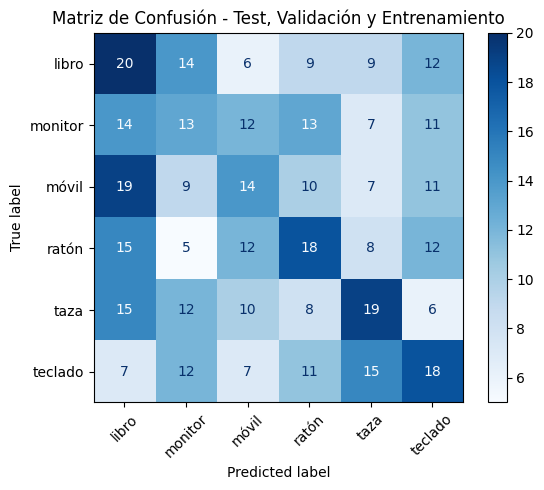

In [16]:
def get_predictions(generator):
    """
    Realiza predicciones y devuelve las etiquetas verdaderas y predichas.
    """
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    return y_true, y_pred_classes

# Obtener predicciones del conjunto de test
y_true_test, y_pred_test = get_predictions(test_generator)

# Obtener predicciones del conjunto de validación
y_true_val, y_pred_val = get_predictions(val_generator)

# Obtener predicciones del conjunto de entrenamiento
y_true_train, y_pred_train = get_predictions(train_generator)

# Concatenar todas las predicciones
y_true_all = np.concatenate([y_true_test, y_true_val, y_true_train])
y_pred_all = np.concatenate([y_pred_test, y_pred_val, y_pred_train])

# Crear la matriz de confusión
labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true_all, y_pred_all)

# Mostrar la matriz de confusión
plt.figure(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Matriz de Confusión - Test, Validación y Entrenamiento')
plt.show()

1. Clases y sus errores:

*  Libro:

20 imágenes clasificadas correctamente.

14 imágenes confundidas con monitor.

6 imágenes confundidas con móvil.

9 imágenes confundidas con ratón.

9 imágenes confundidas con taza.

12 imágenes confundidas con teclado.

*  Monitor:

13 imágenes clasificadas correctamente.

14 imágenes confundidas con libro.

12 imágenes confundidas con móvil.

13 imágenes confundidas con ratón.

7 imágenes confundidas con taza.

11 imágenes confundidas con teclado.

*  Móvil:

14 imágenes clasificadas correctamente.

19 imágenes confundidas con libro.

9 imágenes confundidas con monitor.

10 imágenes confundidas con ratón.

7 imágenes confundidas con taza.

11 imágenes confundidas con teclado.

*  Ratón:

18 imágenes clasificadas correctamente.

15 imágenes confundidas con libro.

5 imágenes confundidas con monitor.

12 imágenes confundidas con móvil.

8 imágenes confundidas con taza.

12 imágenes confundidas con teclado.

*  Taza:

19 imágenes clasificadas correctamente.

15 imágenes confundidas con libro.

12 imágenes confundidas con monitor.

10 imágenes confundidas con móvil.

8 imágenes confundidas con ratón.

6 imágenes confundidas con teclado.

*  Teclado:

18 imágenes clasificadas correctamente.

7 imágenes confundidas con libro.

12 imágenes confundidas con monitor.

7 imágenes confundidas con móvil.

11 imágenes confundidas con ratón.

15 imágenes confundidas con taza.

# 12. Guardar el modelo

In [17]:
os.makedirs('models', exist_ok=True)
model.save('models/modelo_multiclase.h5')

print("\nModelo guardado en 'models/modelo_multiclase.h5'")


Modelo guardado en 'models/modelo_multiclase.h5'
